In this project we are going to convert a bunch of tweets turn them into word emmbedings reduce their dimniality to 25 with autoencoders and then reduce that to 2 usning TSNE and plot them all using matplotlib

In [ ]:
%matplotlib notebook
import re
import tqdm
import keras
import word2vec
import numpy as np
from keras import layers
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [ ]:
data=np.load('twitter_data.npz',encoding='bytes')['data']
at_pat=re.compile("@.\w*")
hash_pat=re.compile("#.\w*")
link_pat1=re.compile("http://.*'")
link_pat2=re.compile("http://.*\\'")
link_pat7=re.compile('http://.*"')
link_pat8=re.compile('http://.*\\"')
link_pat3=re.compile("https://.*'")
link_pat4=re.compile("https://.*\\'")
link_pat5=re.compile('https://.*\\"')
link_pat6=re.compile('https://.*"')
w2v=word2vec.load('model.bin')
text=data[:,19]
tsne=TSNE()
wpat=re.compile('\w+')

In [3]:
# clean the data and save them into a text file for word2vec
def genline():
    for i in text:
        i=str(i).replace('b\'','')
        for at in at_pat.findall(i):
            i=i.replace(at,'ATACCOUNT')
        for at in hash_pat.findall(i):
            i=i.replace(at,'HASHTAG')
        for at in link_pat1.findall(i):
            i=i.replace(at,'LINK')
        for at in link_pat2.findall(i):
            i=i.replace(at,'LINK')
        for at in link_pat3.findall(i):
            i=i.replace(at,'LINK')
        for at in link_pat4.findall(i):
            i=i.replace(at,'LINK')
        for at in link_pat5.findall(i):
            i=i.replace(at,'LINK')    
        for at in link_pat6.findall(i):
            i=i.replace(at,'LINK')
        for at in link_pat7.findall(i):
            i=i.replace(at,'LINK')
        for at in link_pat8.findall(i):
            i=i.replace(at,'LINK')
        yield i

s_clean=[i for i in genline()]
for i in s_clean:
    open('data_raw_n.txt','a').write(i)

In [6]:
#train on the raw data
word2vec.word2vec('data_raw_n.txt','model.bin',size=500, verbose=True)

Starting training using file data_raw_n.txt
Vocab size: 3351
Words in train file: 151298
Alpha: 0.000002  Progress: 102.90%  Words/thread/sec: 58.41k  

In [50]:
#convert the data into static size arrays of word emmbedings 
x=np.empty((1450,10,500))
for i in tqdm.tqdm_notebook(range(0,1450)):
    c_text=s_clean[i].split(' ')
    if len(c_text)>10:
        c_text=c_text[:10]
    if len(c_text)<10:
        c_text=c_text+ ['' for i in range(0,10-len(c_text))]
    
    w2_v=np.empty((10,500))
    for ind in range(0,10):
        try:
            w2_v[ind]=w2v[c_text[ind].replace("'",'').replace('"','').replace('.','')]
        except:
            pass
    x[i]=w2_v


HBox(children=(IntProgress(value=0, max=1450), HTML(value='')))

In [58]:
l=layers.Input((10,500))

_Rencoder_1=layers.SimpleRNN(500,return_sequences=True)

Rencoder_1=_Rencoder_1(l)
Aencoder_1=layers.Activation('relu')(Rencoder_1)
Dencoder_1=layers.Dropout(0.5)(Aencoder_1)

_Rencoder_2=layers.SimpleRNN(100,return_sequences=True)

Rencoder_2=_Rencoder_2(Dencoder_1)
Aencoder_2=layers.Activation('relu')(Rencoder_2)
Dencoder_2=layers.Dropout(0.5)(Aencoder_2)


_Rencoder_3=layers.SimpleRNN(25,return_sequences=True)

Rencoder_3=_Rencoder_3(Dencoder_2)
Aencoder_3=layers.Activation('relu')(Rencoder_3)
Dencoder_3=layers.Dropout(0.5)(Aencoder_3)


_Rdecoder_1=layers.SimpleRNN(100,return_sequences=True)

Rdecoder_1=_Rdecoder_1(Dencoder_3) 
Adecoder_1=layers.Activation('relu')(Rdecoder_1)

_Rdecoder_2=layers.SimpleRNN(500,return_sequences=True)

Rdecoder_2=_Rdecoder_2(Adecoder_1) 
Adecoder_2=layers.Activation('softmax')(Rdecoder_2)

model_ae=keras.models.Model(l,Adecoder_2)
model_ae.compile('adam','mse')

In [59]:
# train an RNN autoencoder
model_ae.fit(x,x,batch_size=50,epochs=15)

Epoch 1/15
1450/1450 [==============================] - 23s 16ms/step - loss: 0.0020
Epoch 2/15
1450/1450 [==============================] - 18s 13ms/step - loss: 0.0019
Epoch 3/15
1450/1450 [==============================] - 18s 13ms/step - loss: 0.0019
Epoch 4/15
1450/1450 [==============================] - 18s 12ms/step - loss: 0.0019
Epoch 5/15
1450/1450 [==============================] - 17s 12ms/step - loss: 0.0019
Epoch 6/15
1450/1450 [==============================] - 18s 12ms/step - loss: 0.0019
Epoch 7/15
1450/1450 [==============================] - 18s 12ms/step - loss: 0.0019
Epoch 8/15
1450/1450 [==============================] - 18s 12ms/step - loss: 0.0019
Epoch 9/15
1450/1450 [==============================] - 18s 12ms/step - loss: 0.0019
Epoch 10/15
1450/1450 [==============================] - 18s 13ms/step - loss: 0.0019
Epoch 11/15
1450/1450 [==============================] - 18s 12ms/step - loss: 0.0019
Epoch 12/15
1450/1450 [==============================] - 18s 12

In [60]:
model_ae.save_weights('model_ae.bin')

In [61]:
l=layers.Input((10,500))

e1=_Rencoder_1(l) # use layers from autoencoder model to shrink the data with the traind weights 
e1=layers.Activation('relu')(e1)

e2=_Rencoder_2(e1)
e2=layers.Activation('relu')(e2)

e3=_Rencoder_3(e2)
e3=layers.Activation('softmax')(e3)

model=keras.models.Model(l,e3)
model.compile('adam','mse')

In [62]:
text_shrunck=model.predict(x) # use half of the autoencoder to trnasform the data from 500 dims to 25 dims
text_shrunck=np.asarray([i.flatten() for i in text_shrunck])
Data_ready=tsne.fit_transform(text_shrunck) #apply TSNE to transform it from 25 dims to 2

<IPython.core.display.Javascript object>


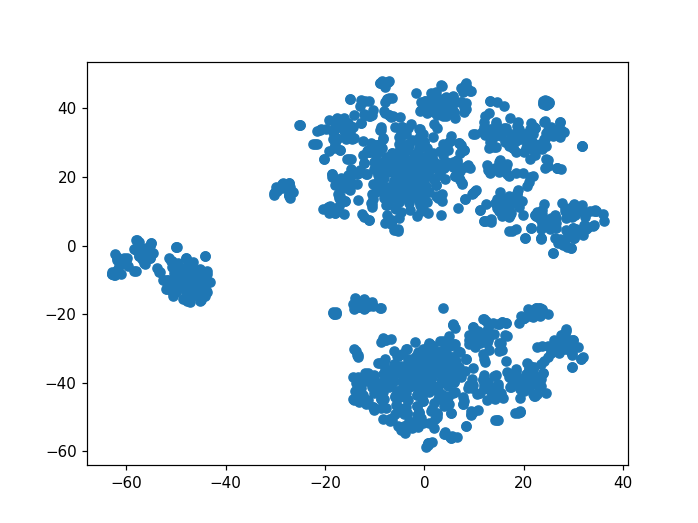

In [1]:
#plot the data
x,y=Data_ready[:,0],Data_ready[:,1]
fig, ax = plt.subplots()
ax.scatter(x,y) 

In [7]:
np.savez_compressed('data2d.npz',x=x,y=y,text=text)